# Importing Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing


import os
import pathlib
from IPython import display

======================================================================================================================

# Importing Data

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 130s 1us/step


======================================================================================================================

# Reading & Preparing Data

In [6]:
Words = np.array(tf.io.gfile.listdir(str(data_dir)))
Words = Words[Words != 'README.md']
print('Words:', Words)

Words: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [10]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
NumOfSamples = len(filenames)
print('Number of total records:', NumOfSamples)
print('Number of records per label:', len(tf.io.gfile.listdir(str(data_dir/Words[0]))))

Number of total records: 8000
Number of records per label: 1000


In [15]:
TrainingData = filenames[:6400]
ValidationData = filenames[6400: 6400 + 800]
TestingData = filenames[-800:]

print('Training Data Size -->', len(TrainingData))
print('Validation Data Size -->', len(ValidationData))
print('Testing Data Size -->', len(TestingData))

Training Data Size --> 6400
Validation Data Size --> 800
Testing Data Size --> 800


======================================================================================================================

# Data Analysis & Understanding 

In [16]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [17]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] 

In [18]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [19]:
files_ds = tf.data.Dataset.from_tensor_slices(TrainingData)
waveform_ds = files_ds.map(get_waveform_and_label)

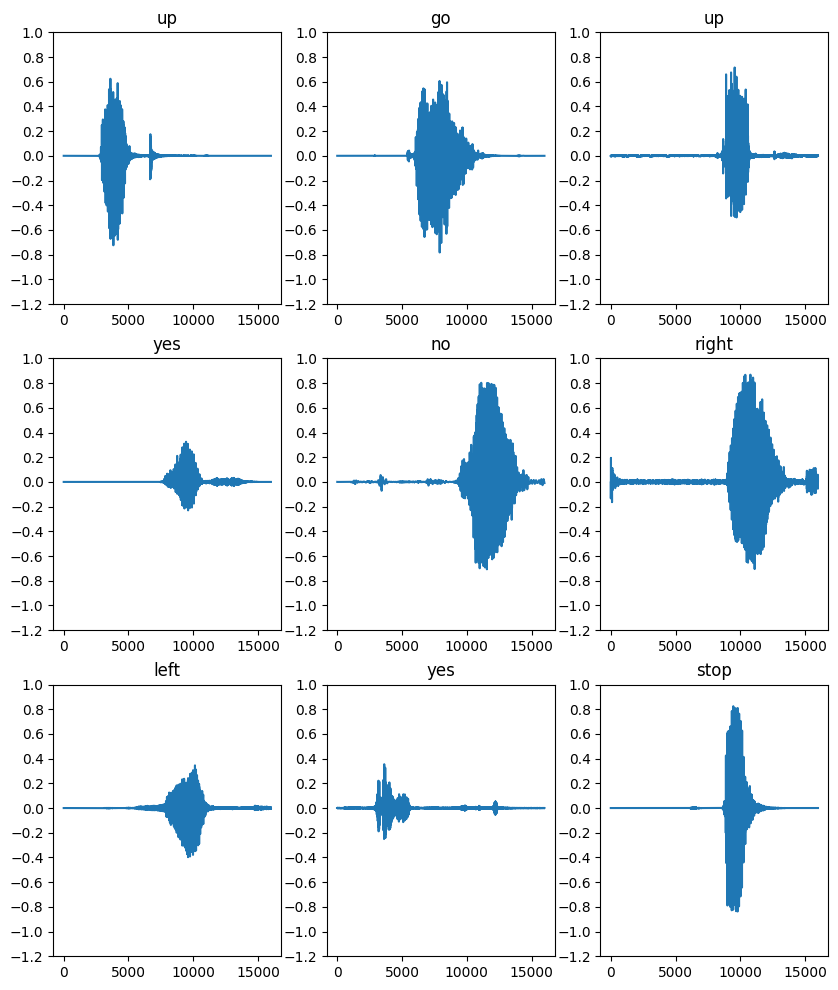

In [21]:
rows = 3
cols = 3
n = rows*cols

with plt.style.context('default'):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
    for i, (audio, label) in enumerate(waveform_ds.take(n)):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(audio.numpy())
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        label = label.numpy().decode('utf-8')
        ax.set_title(label)

plt.show()

In [22]:
def get_spectrogram(waveform):
    
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [25]:
for waveform, label in waveform_ds.take(3):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


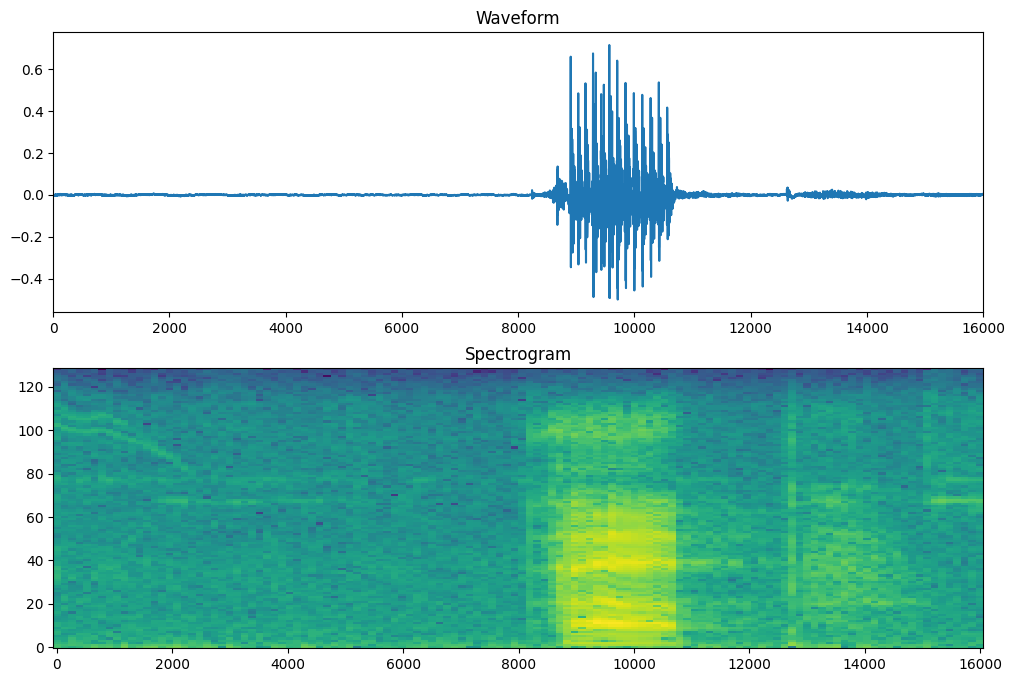

In [26]:
def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(16000, step=height + 1)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

with plt.style.context('default'):
    fig, axes = plt.subplots(2, figsize=(12, 8))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy())
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, 16000])
    plot_spectrogram(spectrogram.numpy(), axes[1])
    axes[1].set_title('Spectrogram')
    plt.show()

In [27]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == Words)
    return spectrogram, label_id

In [28]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id)

C:\Users\omara\AppData\Local\Temp/ipykernel_15048/1934618365.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


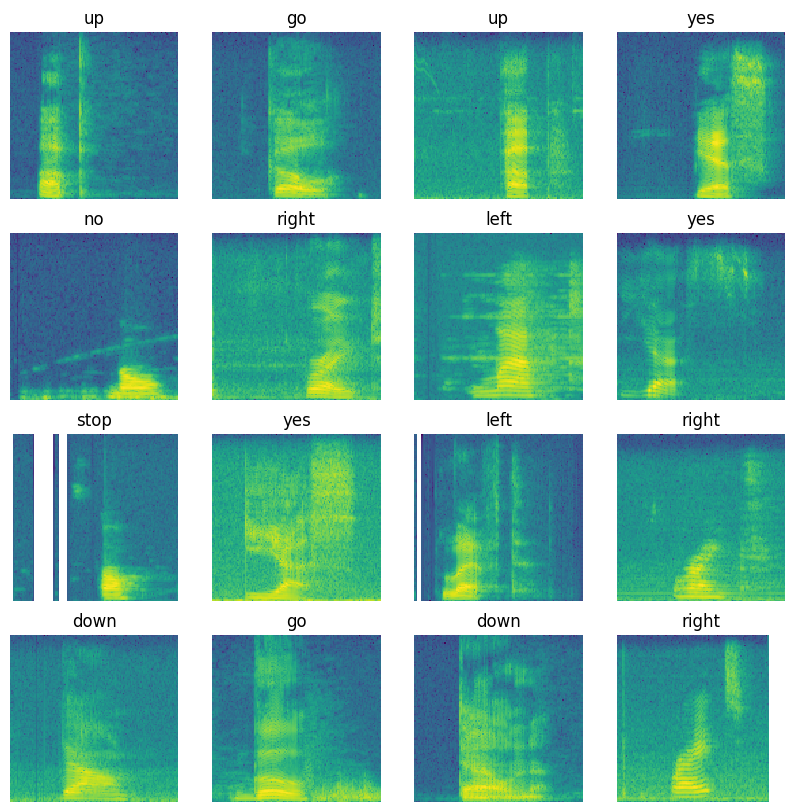

In [31]:
rows = 4
cols = 4
n = rows*cols
with plt.style.context('default'):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
        ax.set_title(Words[label_id.numpy()])
        ax.axis('off')
    plt.show()

======================================================================================================================

# Data Pre-Processing

In [32]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label)
    output_ds = output_ds.map(
      get_spectrogram_and_label_id)
    return output_ds

In [33]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(ValidationData)
test_ds = preprocess_dataset(TestingData)

In [34]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [35]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()

======================================================================================================================

# Building Model

In [37]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('Input shape:', input_shape)
    num_labels = len(Words)

    norm_layer = preprocessing.Normalization()
    norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

    model = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing.Resizing(32, 32), 
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])

    model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [39]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 11s 105ms/step - loss: 1.6973 - accuracy: 0.3958 - val_loss: 1.3144 - val_accuracy: 0.5813
Epoch 2/10
100/100 [==============================] - 8s 82ms/step - loss: 1.1374 - accuracy: 0.5975 - val_loss: 0.9478 - val_accuracy: 0.6787
Epoch 3/10
100/100 [==============================] - 8s 79ms/step - loss: 0.8614 - accuracy: 0.6956 - val_loss: 0.7817 - val_accuracy: 0.7287
Epoch 4/10
100/100 [==============================] - 8s 82ms/step - loss: 0.6968 - accuracy: 0.7503 - val_loss: 0.6789 - val_accuracy: 0.7675
Epoch 5/10
100/100 [==============================] - 8s 79ms/step - loss: 0.5960 - accuracy: 0.7922 - val_loss: 0.6169 - val_accuracy: 0.7812
Epoch 6/10
100/100 [==============================] - 8s 81ms/step - loss: 0.4983 - accuracy: 0.8241 - val_loss: 0.5511 - val_accuracy: 0.8100
Epoch 7/10
100/100 [==============================] - 8s 82ms/step - loss: 0.4497 - accuracy: 0.8422 - val_loss: 0.5466 - val_accuracy: 0.79

======================================================================================================================

# Model Evaluation 

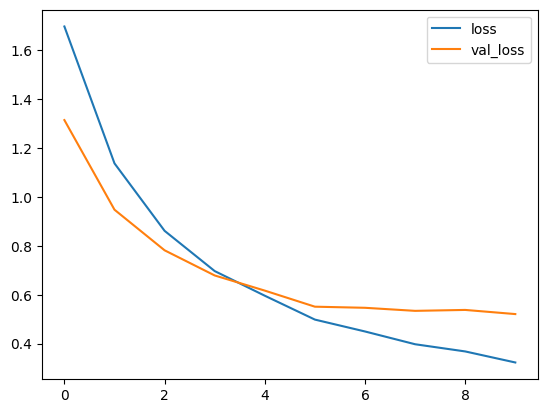

In [40]:
metrics = history.history
with plt.style.context('default'):
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [41]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [47]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test Data Accuracy: {test_acc:.0%}')

Test Data Accuracy: 85%


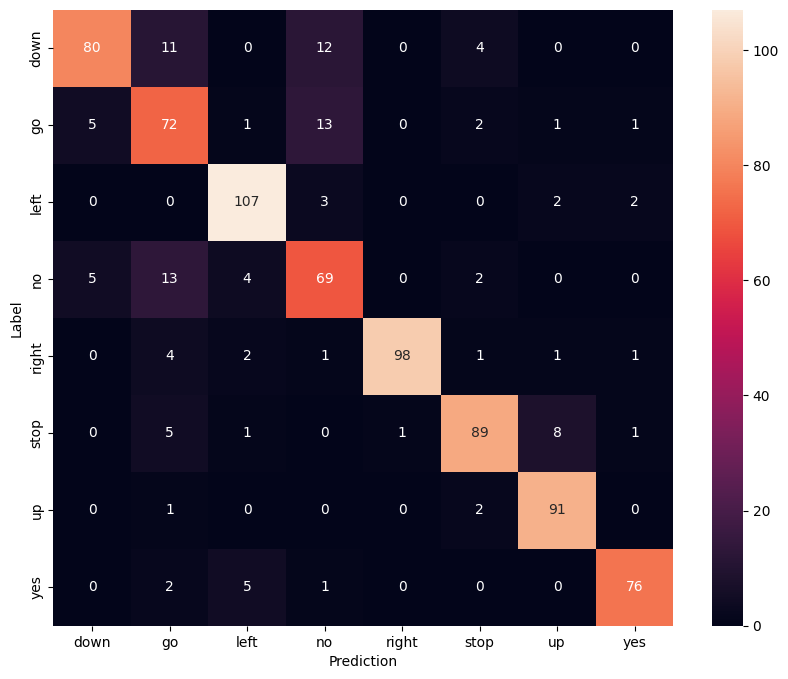

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
with plt.style.context('default'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=Words, yticklabels=Words, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

======================================================================================================================

# Testing the performance of the model

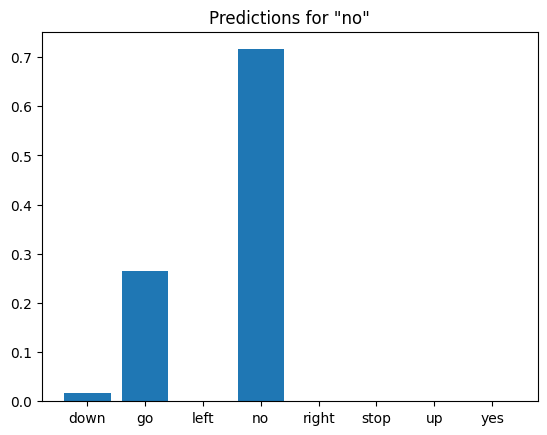

In [45]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  with plt.style.context('default'):
    plt.bar(Words, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{Words[label[0]]}"')
    plt.show()

======================================================================================================================